<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/3_fgsm_image_adversaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

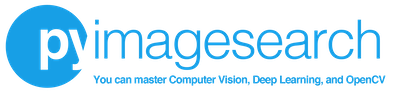

# Adversarial attacks with FGSM (Fast Gradient Sign Method)

### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [
Adversarial attacks with FGSM (Fast Gradient Sign Method)](https://www.pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/) blog post published on 03-01-21.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible joining PyImageSearch Plus at [http://pyimg.co/plus/](http://pyimg.co/plus) today.*

### Download the code zip file

In [ ]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/fgsm-image-adversaries/fgsm-image-adversaries.zip
!unzip -qq fgsm-image-adversaries.zip
%cd fgsm-image-adversaries.zip

--2021-08-26 03:40:42--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/fgsm-image-adversaries/fgsm-image-adversaries.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.145.10
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.145.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6319 (6.2K) [binary/octet-stream]
Saving to: ‘fgsm-image-adversaries.zip’

fgsm-image-adversar 100%[===================>]   6.17K  --.-KB/s    in 0s      

2021-08-26 03:40:43 (205 MB/s) - ‘fgsm-image-adversaries.zip’ saved [6319/6319]

[Errno 20] Not a directory: 'fgsm-image-adversaries.zip'
/content


## Blog Post Code

### Import Packages

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MSE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [ ]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Creating a simple CNN architecture for adversarial training

In [ ]:
class SimpleCNN:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# first CONV => RELU => BN layer set
		model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))

		# second CONV => RELU => BN layer set
		model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

### Implementing the Fast Gradient Sign Method with Keras and TensorFlow


In [ ]:
def generate_image_adversary(model, image, label, eps=2 / 255.0):
	# cast the image
	image = tf.cast(image, tf.float32)

	# record our gradients
	with tf.GradientTape() as tape:
		# explicitly indicate that our image should be tacked for
		# gradient updates
		tape.watch(image)

		# use our model to make predictions on the input image and
		# then compute the loss
		pred = model(image)
		loss = MSE(label, pred)

	# calculate the gradients of loss with respect to the image, then
	# compute the sign of the gradient
	gradient = tape.gradient(loss, image)
	signedGrad = tf.sign(gradient)

	# construct the image adversary
	adversary = (image + (signedGrad * eps)).numpy()

	# return the image adversary to the calling function
	return adversary

### Creating our adversarial training script

In [ ]:
# load MNIST dataset and scale the pixel values to the range [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# one-hot encode our labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

[INFO] loading MNIST dataset...
11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# initialize our optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=1e-3)
model = SimpleCNN.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the simple CNN on MNIST
print("[INFO] training network...")
model.fit(trainX, trainY,
	validation_data=(testX, testY),
	batch_size=64,
	epochs=10,
	verbose=1)

# make predictions on the testing set for the model trained on
# non-adversarial images
(loss, acc) = model.evaluate(x=testX, y=testY, verbose=0)
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


[INFO] training network...
Epoch 1/10
938/938 [==============================] - 19s 4ms/step - loss: 0.2057 - accuracy: 0.9391 - val_loss: 0.0683 - val_accuracy: 0.9785
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0829 - accuracy: 0.9755 - val_loss: 0.0471 - val_accuracy: 0.9849
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0624 - accuracy: 0.9809 - val_loss: 0.0419 - val_accuracy: 0.9860
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0517 - accuracy: 0.9841 - val_loss: 0.0444 - val_accuracy: 0.9856
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0424 - accuracy: 0.9866 - val_loss: 0.0389 - val_accuracy: 0.9876
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0376 - accuracy: 0.9879 - val_loss: 0.0437 - val_accuracy: 0.9861
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0338 - accuracy: 0.9894 - val_loss: 0.0441 -

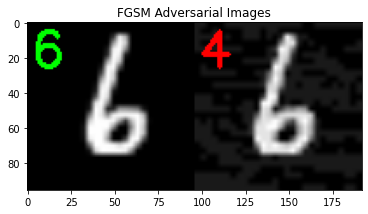

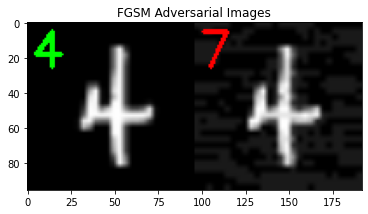

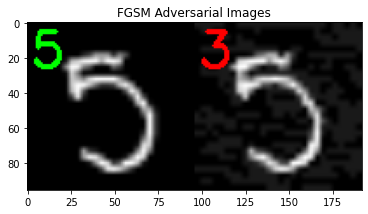

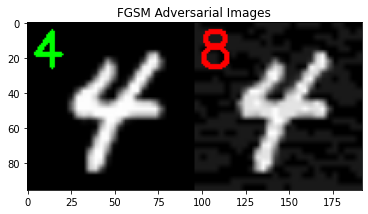

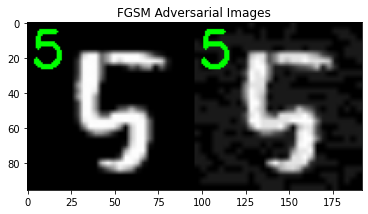

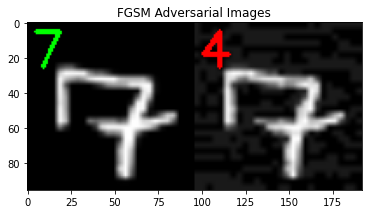

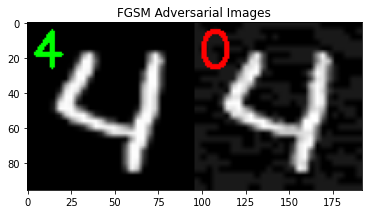

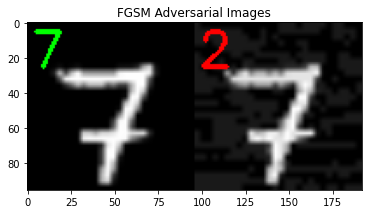

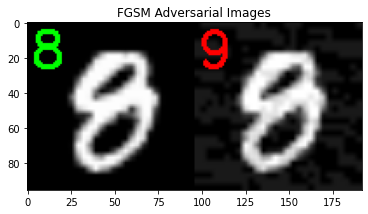

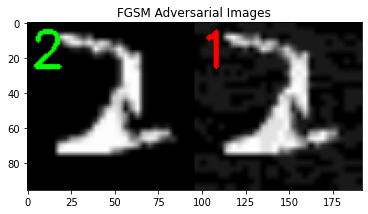

In [ ]:
# loop over a sample of our testing images
for i in np.random.choice(np.arange(0, len(testX)), size=(10,)):
	# grab the current image and label
	image = testX[i]
	label = testY[i]

	# generate an image adversary for the current image and make
	# a prediction on the adversary
	adversary = generate_image_adversary(model,
		image.reshape(1, 28, 28, 1), label, eps=0.1)
	pred = model.predict(adversary)

	# scale both the original image and adversary to the range
	# [0, 255] and convert them to an unsigned 8-bit integers
	adversary = adversary.reshape((28, 28)) * 255
	adversary = np.clip(adversary, 0, 255).astype("uint8")
	image = image.reshape((28, 28)) * 255
	image = image.astype("uint8")

	# convert the image and adversarial image from grayscale to three
	# channel (so we can draw on them)
	image = np.dstack([image] * 3)
	adversary = np.dstack([adversary] * 3)

	# resize the images so we can better visualize them
	image = cv2.resize(image, (96, 96))
	adversary = cv2.resize(adversary, (96, 96))

	# determine the predicted label for both the original image and
	# adversarial image
	imagePred = label.argmax()
	adversaryPred = pred[0].argmax()
	color = (0, 255, 0)

	# if the image prediction does not match the adversarial
	# prediction then update the color
	if imagePred != adversaryPred:
		color = (0, 0, 255)

	# draw the predictions on the respective output images
	cv2.putText(image, str(imagePred), (2, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)
	cv2.putText(adversary, str(adversaryPred), (2, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

	# stack the two images horizontally and then show the original
	# image and adversarial image
	output = np.hstack([image, adversary])
	plt_imshow("FGSM Adversarial Images", output)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [
*Adversarial attacks with FGSM (Fast Gradient Sign Method*)](https://www.pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/) published on 03-01-21.

---



# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```